Asynchronous Material 23
============================

Convection is a buoyancy instability; instabilities are the flip sides of waves.  They emerge when the solution to the dispersion relationship yields a imaginary (or complex) frequency rather than a real one.  The real part contains information about oscillations, while the imaginary part contains exponential growth or decay.

# Things to read
I'd suggest reading both of these this week.
1. Chodhuri chapter 9 ("Rotation and hydrodynamics")
2. Chandrasekhar chapter 2 ("The effect of rotation")


# Exercises

1. Watch [Intuition for nonlinear convection (16 min)](https://youtu.be/LqJ8eWhJm7Q)

2. Work through the material below.  This is a two part exercise, and there are two participation parts.
    1. The first part involves analytic approaches (you'll use `sympy`) to convective onset.  
    2. The second part involves computing numerical critical Rayleigh numbers.  

This notebook will require `sympy` and `dedalus` to complete, but the initial coding of the dedalus problem is done for you.

## Part I: analytic approaches to instabilities

We've learned that the ideal, linearized Boussinesq system has this dispersion relationship:
\begin{align}
    \omega^2 = \frac{m^2}{m^2+k^2}N^2
\end{align}
with $N^2 = \alpha g \nabla T_0$.  When $\nabla T_0 > 0$, $N^2 > 0$, $\omega \in \mathbb{R}$, and we have stable, oscillating gravity waves.

What about when $\nabla T_0 < 0$?  Now $N^2 < 0$ and $\omega \in \mathbb{C}$ and perturbations can grow or decay (exponentially) in time.  This is an unstable solution.  

If $\omega$ has no real part, this is sometimes called a "direct instability, and the instability onsets via a "supercritical bifurcation".  We will see that this is how convection onsets for simple thermal convection in a simple Rayleigh-Benard system.  

When $\omega$ has a real part as well, then the onset is via an "oscillatory instability", and typically a "subcritical bifurcation".  These instabilites show up in systems with competing physical effects, like thermosolutal convection, doubly-diffusive convection in general, and in some cases for rotating convection (and in many, many other systems).

If you'd like to learn more about bifurcations, you can start at this Wikipedia page on [Hopf bifurcations](https://en.wikipedia.org/wiki/Hopf_bifurcation), and I can also recommend [Introduction to Hydrodynamic Stability by Drazin](https://www.amazon.com/Introduction-Hydrodynamic-Stability-Cambridge-Mathematics-dp-0521009650/dp/0521009650).

$\renewcommand{\vec}{\boldsymbol}$
Here, let's learn about Rayleigh-Benard convective instability two ways.  The linear, non-dimensional equations are:
\begin{gather}
\frac{\partial}{\partial t} \vec{u} + \vec{\nabla} \varpi - \mathrm{Ra}\mathrm{Pr}T\vec{\hat{z}} -\mathrm{Pr}\nabla^2\vec{u}= 0 \\
\frac{\partial}{\partial t} T + \vec{u}\cdot\vec{\nabla} T_0 - \nabla^2 T= 0 \\
\vec{\nabla}\cdot\vec{u} = 0
\end{gather}
or in component form (assuming 2-D perturbations):
\begin{gather}
\frac{\partial}{\partial t} w + \frac{\partial}{\partial z} \varpi - \mathrm{Ra}\mathrm{Pr}T -\mathrm{Pr}\left(\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial z^2}\right) w  = 0 \\
\frac{\partial}{\partial t} u + \frac{\partial}{\partial x} \varpi -\mathrm{Pr}\left(\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial z^2}\right) u= 0 \\
\frac{\partial}{\partial t} T + w\nabla T_0 -\left(\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial z^2}\right) T = 0 \\
\frac{\partial}{\partial z} w + \frac{\partial}{\partial x} u  = 0
\end{gather}
Recall that:
\begin{align}
    \mathrm{Ra} = -\frac{\alpha g \nabla T_0 L^4}{\nu \chi} \qquad \mathrm{Pr} = \frac{\nu}{\chi}
\end{align}
where this is related to the form you've seen previously by recognizing that $\Delta T_0 = -L\nabla T_0$ for a linear temperature gradient.  The big difference from the linear wave equations is that here we've included diffusive terms for both temperature and momentum.

What do we do about these Laplacian terms?  As with waves, we will adopt a modal decomposition:
\begin{align}
    u, w, T, \varpi \propto e^{i \omega t} e^{-i m x} f_\omega(z),
\end{align}
but note that this time we've left the vertical eigenfunction $f_\omega(z)$ general, and note that this is a function of both $z$ and $\omega$ in general.  Why did we do this?  Unlike our wave problems, convection has boundaries, and the vertical eigenfunctions must respect those boundary conditions.  

Here in lies the difficulty.  The horizontal modal decomposition remains the eigenfunction of the derivative operator, but $f(z)$ is the eigenfunction of the linear operator and may not be an eigenfunction of the vertical derivative operator alone (this all works in the horizontal direction because this problem is separable; not all problems are).
Now we need to solve an eigenvalue/eigenfunction problem to obtain $\omega$ and $f_\omega(z)$, the eigenvalue/eigenfunction pairs.


We now explore two different ways of solving for the onset of convective instabilty.  If the boundary conditions are particulary simple, we can select the form of $f(z)$ by hand and solve analytically.  If the boundary conditions are general however, we will need to do a numerical solution to an EigenValue Problem `EVP` using Dedalus.

In all cases, we will be searching for cases where $\omega^2 \in \mathbb{C}$ and $\omega^2 \notin \mathbb{R}$.

Boundary conditions
------------------

When we talk about boundary conditions, what we're talking about are the values that perturbations assume at $z=0$ and $z=1$ (the top and bottom of the domain).  The horizontal boundary conditions are implicity periodic, based on the modal expansion we took for the horizontal structure of the fluctuations (though other modal expansions, like a `Sin` or `Cos` series could be used to model other special choices).

Typically, there are choices about the thermal and the velocity perturbations at the boundary.  Our 2-D problem here is 6th order, and so will need a total of 6 boundary conditions (8 in 3-D, but Rayleigh-Benard convection happens to onset as a 2-D mode).

Classic velocity boundary conditions are that the top and bottom are impenetrable (no velocity normal to the boundary at the boundary):
\begin{align}
    w = 0 \: \text{at} \: z=0,1
\end{align}
and that the horizontal conditions are either "no-slip":
\begin{align}
    u = 0 \: \text{at} \: z=0,1
\end{align}
or "stress-free" (sometimes just called "free"):
\begin{align}
    \frac{\partial u}{\partial z} = 0 \: \text{at} \: z=0,1
\end{align}
The real world is typically "no-slip", but as we'll see "stress-free" has nice properties for analytic solutions.

Classic thermal boundary conditions are that the top and bottom are either "constant temperature":
\begin{align}
    T = 0 \: \text{at} \: z=0,1
\end{align}
or "fixed flux"
\begin{align}
    \frac{\partial T}{\partial z} = 0 \: \text{at} \: z=0,1
\end{align}
called this because a constant temperature gradient normal to the boundary leads to a constant diffusive flux $\chi \nabla T$.  Note in all cases that the $T$ here is the fluctuating $T$; the background state $T_0$ for example is not zero at either boundary.

In the real world, mixed boundary conditions are not at all out of the question.  For example, a pot of water on a stove might be close to "no-slip" at the bottom and "stress-free" at the air/water interface, and the thermal boundary conditions might be a mix too (what do you think they are for a pot in your kitchen?). 

Analytic approaches to Rayleigh-Benard
------------------------------------

We begin with analytic approaches for searching for the Rayleigh-Benard instability.  This follows the discussion in Chapter 7.3 of [Choudhuri](https://www.amazon.com/Physics-Fluids-Plasmas-Introduction-Astrophysicists/dp/0521555434/) and also the classic text [Hydrodynamic and Hydromagnetic Stability by Chandrasekhar](https://www.amazon.com/Hydrodynamic-Hydromagnetic-Stability-International-Monographs-dp-048664071X/dp/048664071X) (section I.15).

If the boundary conditions are "impenetrable" and "stress-free" at top and bottom, then it turns out that
\begin{align}
    f_w(z) = \sin(\pi n z) \\
    f_u(z) = \cos(\pi n z)    
\end{align}
are valid solutions for the vertical velocity $w$ and $u$ eigenfunctions, with $n$ an integer.  You can test this by taking $\partial/\partial z$ of $f_u(z)$; it's zero at top and bottom.  Likewise for $f_w(z)$, and you can also see that they have correct parities to make $\nabla \cdot \vec{u}$ make sense.  

What are the other eigenfunctions?  Well, the horizontal momentum equation has a $\partial \varpi/\partial x$ term that projects onto $\partial u/\partial t$, and neither of those changes the parity of the vertical eigenfunction.  Hence:
\begin{align}
    f_\varpi(z) = \cos(\pi n z).
\end{align}
Likewise, in the temperature equation, $w\nabla T_0 = -w$ (with $\nabla T_0 = -1$) projects onto $\partial T/\partial t$, with no parity modification, so  
\begin{align}
    f_T(z) = \sin(\pi n z).
\end{align}
and you can double check that the bouyancy term in the vertical momentum equation now has the right set of parities too.  So if we have "fixed temperature" thermal boundary conditions, we're in luck (if we don't, none of this will work and we need to go to part II!).


With all of that, let's take "impenetrable, stress free, fixed temperature" boundaries.  These eigenfunctions all happen to be eigenfunctions of the vertical derivative operator, so the whole system reduces to a linear matrix system.

Here we get really lucky and all of the parities work out (each equation is only a single parity: $\sin$ or $\cos$).  Mixed parity PDEs are a mess, as these two papers discuss in detail: [A new method for fast transforms in parity-mixed PDEs: Part I. Numerical techniques and analysis](https://www.sciencedirect.com/science/article/pii/S0021999108002441) and [A new method for fast transforms in parity-mixed PDEs: Part II. Application to confined rotating convection](https://www.sciencedirect.com/science/article/pii/S0021999108002428) (each one is a Vasil et al 2008).

But here we're lucky and can ignore all of that.  So let's proceed.  Taking $\nabla T_0 = -1$, the linear system is:

In [34]:
import sympy as sym
sym.init_printing()
ω = sym.symbols('ω')
m = sym.symbols('m', real=True, nonzero=True)
n = sym.symbols('n', integer=True)
Ra, Pr = sym.symbols('Ra, Pr', positive=True, real=True, nonzero=True)
i = sym.I
π = sym.pi
A = sym.Matrix([[ i*ω+Pr*(m**2+π**2*n**2),      0, -Ra*Pr, -n*π],
                [   0,    i*ω+Pr*(m**2+π**2*n**2),    0, -i*m],
                [-1,   0,  i*ω+(m**2+π**2*n**2),    0],
                [n*π,   -i*m,    0,    0]])
display(A)

⎡   ⎛ 2    2  2⎞                                                     ⎤
⎢Pr⋅⎝m  + π ⋅n ⎠ + ⅈ⋅ω            0                 -Pr⋅Ra       -π⋅n⎥
⎢                                                                    ⎥
⎢                          ⎛ 2    2  2⎞                              ⎥
⎢          0            Pr⋅⎝m  + π ⋅n ⎠ + ⅈ⋅ω         0          -ⅈ⋅m⎥
⎢                                                                    ⎥
⎢                                               2    2  2            ⎥
⎢         -1                      0            m  + π ⋅n  + ⅈ⋅ω   0  ⎥
⎢                                                                    ⎥
⎣         π⋅n                   -ⅈ⋅m                  0           0  ⎦

Note that we were careful to take $\partial \varpi/\partial z = -\pi n$ because of the parity change:
\begin{align}
    \frac{\partial}{\partial z} \cos(z) \rightarrow -\sin(z)
\end{align}
The determinant of this system is a mess.  But let's think about what we can learn.

Our goal is to find the critical value of the Rayleigh number $\mathrm{Ra}$ at which convection will begin (go unstable).  Below this value, diffusion will dominate the problem and nothing will happen.  Above this value, the instability will grow and nonlinear convection will occur.  

Let's see if we can solve analytically for the critical value of the Rayleigh number. To do so, we employ some knowledge of the problem to simplify the system and search for the critical value of the Rayleigh number $\mathrm{Ra}$.  These facts are:
1. the instability first sets in for the gravest vertical mode (the one that spans the system).  So
\begin{align}
n=1
\end{align}
2. the instability is a direct onset, supercritical bifurcation.  So at onset:
\begin{align}
\omega = 0
\end{align}

We make these substitutions, we require that $|A|=0$ (to have a non-trivial, infinite set of solutions), and we solve for the value of $\mathrm{Ra}$ that will (at any $m$) satisfy $|A|=0$:

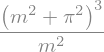

In [2]:
soln = sym.factor(list(sym.solveset(A.det().subs(n,1).subs(ω,0),Ra))[0])
display(soln)
#print('or, in latex')
#print()
# print(r'\mathrm{Ra}_c(m) = '+'{:s}'.format(sym.latex(soln)))

Or 
\begin{align}
    \mathrm{Ra}_c(m) = \frac{\left(m^{2} + \pi^{2}\right)^{3}}{m^{2}}
\end{align}
This is equation 7.25 of Chodhuri and (193) of Chandrasekhar.  Go compare.


Okay, here's where your part comes in.

Participation (Part 1)
--------------------
1. Using something like `sym.lamdify()`, plot $Ra_c(m)$ as a function of $m$, with $m \in (0,5]$.  Check that this reproduces figure 7.3 of Choudhuri.  You probably want to set a smallest $m$ of 0.5 or so.  Use your judgement.
2. Find the miniumum critical Rayleigh number $\mathrm{Ra_c}$ and critical horizontal wavenumber $m_c$ by setting:
\begin{align}
    \frac{\partial}{\partial m} \mathrm{Ra}_c(m) \Big|_{m=m_c} = 0 
\end{align}
Report $\mathrm{Ra_c}$ and $m_c$ both as unevaluated symbols (e.g., with $\pi$s) and as decimals.  Compare to the values in Choudhuri (eqns 7.26 and 7.27).
3. Plot the critical value $\mathrm{Ra}_c$ on your critical curve $\mathrm{Ra}_c(m)$ to make sure that everything makes sense.

Note, you'll probably get a solution $m_c = i \pi$.  That's spurious.  Can you say why?  Reject it regardless.  Also, you'll probably need to make use of the `.evalf()` method from sympy when evaluating your solutions as decimals.  The jupyter notebook `display()` method will help in seeing the symbolic version of the critical wavenumber and Rayleigh number.

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

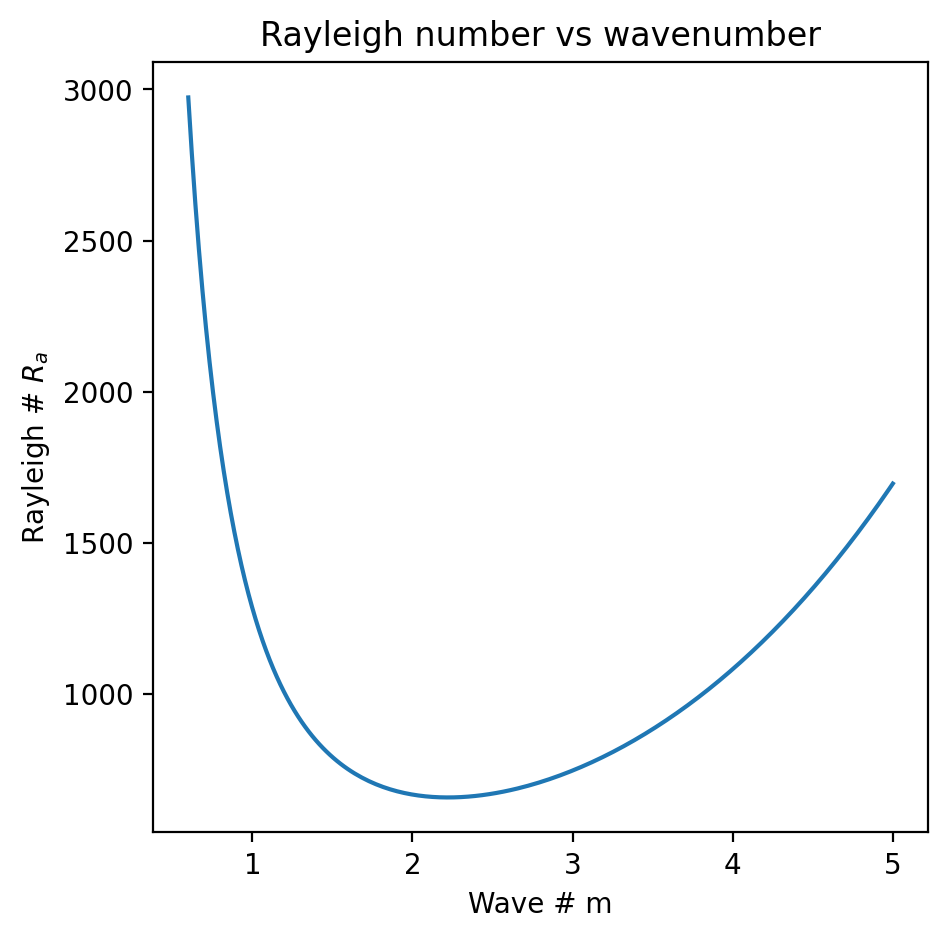

In [73]:
# Problem 1
fig, ax = plt.subplots(figsize = [5,5])

ms = np.linspace(0.6, 5, num = 200)
Ra = sym.lambdify(m, soln)

ax.plot(ms, Ra(ms))
ax.set_title('Rayleigh number vs wavenumber')
ax.set_xlabel('Wave # m')
ax.set_ylabel(r'Rayleigh # $ R_a $');

1) The plot above is almost identical to the one in figure 7.3 of Choudhiri.
2) To find the critical values of $ R_a $ we can compute

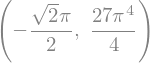

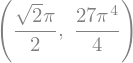

In [77]:
# Problem 2
mcrits = sym.solveset(soln.diff(m), m)
for val in mcrits:
    display((val, soln.subs(m, val)))
    display((val.evalf(), soln.subs(m, val).evalf()))

We can see that the critical point is
$$
    (m, R_a) = \left( \frac{\pi}{\sqrt{2}}, \frac{27}{4}\pi^4 \right) \approx (2.2214, 657.5114).
$$
Note that we see conjugate, purely imaginary roots aswell; purely imaginary wavenumbers imply growth or decay in our solutions instead of the waves we are looking for. 

3) We can add our critical point to the plot to get

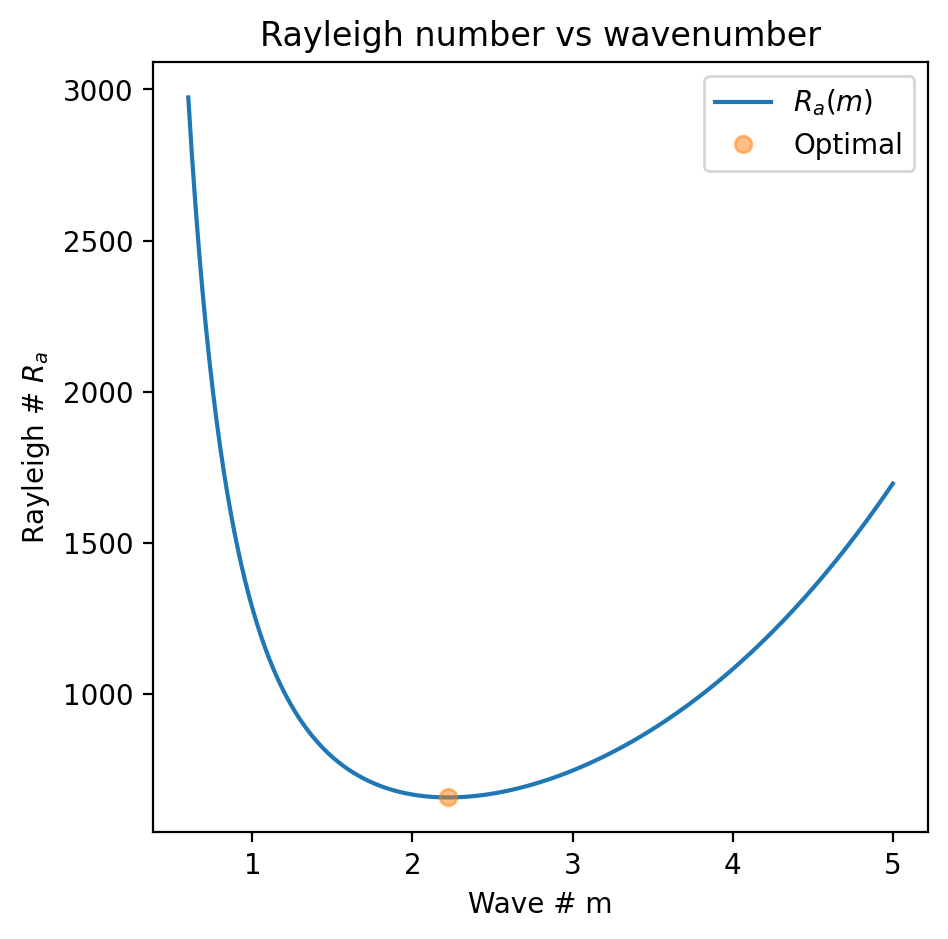

In [78]:
# Problem 3
m_c  = π / np.sqrt(2)
Ra_c = soln.subs(m, m_c)

fig, ax = plt.subplots(figsize = [5,5])
ax.plot(ms, Ra(ms), label = r'$ R_a(m) $')
ax.plot(m_c, Ra_c, 'o', alpha = 0.5, label = 'Optimal')
ax.set_title('Rayleigh number vs wavenumber')
ax.set_xlabel('Wave # m')
ax.set_ylabel(r'Rayleigh # $ R_a $')
ax.legend();

The critical lands at the basin of our curve (at least in the eyeball norm) which is expected

Numerical approaches to Rayleigh-Benard
-----------------------------------
If we have different boundary conditions than this very, very special set (impenetrable, stress free, fixed temp), what do we do?  In general, our eigenfunctions of the problem will no longer be eigenfunctions of the vertical derivative operator, and we're going to have to numerically solve the system.  We can do this a variety of ways.

One method is to do this by solving the eigenvalue problem `EVP` for the critical Rayleigh number, treating $\mathrm{Ra}$ as our eigenvalue and assuming that the onset of instability is direct (e.g., $\omega = 0$ at $\mathrm{Ra}=\mathrm{Ra}_c$).  The code below does just this, for the stress-free, impenetrable, fixed temperature boundary conditions we just solved above analytically.  This happens to work for this problem, but it doesn't work in all problems (see bottom for a discussion of that). 

The code below also wraps in a sophisticated bracketing search method to find the minimum $\mathrm{Ra}_c$ over all continuous $m_c$ (note that $m$ is `k` in the code).

Run this code:

In [140]:
import time
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as de
import logging
logger = logging.getLogger(__name__)

# Boundary conditions flag
conds = 2

def Rayleigh_Benard_onset(kx, Nz, Prandtl = 1, NEV = 10, target = 0):
    if isinstance(kx, np.ndarray):
        kx = kx[0]
    # Parameters
    Nx = 2
    Lx = 2 * np.pi / kx
    Lz = 1

    # Bases
    coords = de.CartesianCoordinates('x', 'z')
    dist   = de.Distributor(coords, dtype=np.complex128)
    xbasis = de.ComplexFourier(coords['x'], size=Nx, bounds=(0, Lx))
    zbasis = de.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz))

    # Fields
    p   = dist.Field(name='p', bases=(xbasis,zbasis))
    b   = dist.Field(name='b', bases=(xbasis,zbasis))
    u   = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
    τp  = dist.Field(name='τp')
    τb1 = dist.Field(name='τb1', bases=xbasis)
    τb2 = dist.Field(name='τb2', bases=xbasis)
    τu1 = dist.VectorField(coords, name='τu1', bases=xbasis)
    τu2 = dist.VectorField(coords, name='τu2', bases=xbasis)

    x, z = dist.local_grids(xbasis, zbasis)
    ex, ez = coords.unit_vector_fields(dist)
    lift_basis = zbasis.derivative_basis(2)
    lift = lambda A, n: de.Lift(A, lift_basis, n)

    e_ij = de.grad(u) + de.trans(de.grad(u)) # stress tensor, for stress-free BCs
    
    dt = lambda A: 0*A # direct onset
    Rayleigh = dist.Field(name='Ra')
    
    # Problem
    problem = de.EVP([p, b, u, τp, τb1, τb2, τu1, τu2], namespace=locals(), eigenvalue=Rayleigh)
    problem.add_equation("div(u) + lift(τu2,-1)@ez + τp = 0")
    problem.add_equation("dt(b) - lap(b) + lift(τb1, -1) + lift(τb2, -2) - ez@u = 0")
    problem.add_equation("dt(u) - Prandtl*lap(u) + grad(p) - Rayleigh*Prandtl*b*ez + lift(τu1,-1) + lift(τu2,-2) = 0")
    problem.add_equation("b(z = 0) = 0")
    problem.add_equation("ez@u(z = 0) = 0")    # impenetrable
    problem.add_equation("b(z = Lz) = 0")
    problem.add_equation("ez@u(z = Lz) = 0")   # impenetrable
    problem.add_equation("integ(p) = 0")       # Pressure gauge
    
    # Stress free BCs
    if conds == 0:
        problem.add_equation("ez@(ex@e_ij(z = 0))  = 0") # Bottom stress free BC
        problem.add_equation("ez@(ex@e_ij(z = Lz)) = 0") # Top stress free BC
        
    # No-slip BCs
    if conds == 1:
        problem.add_equation("ex@u(z = 0)  = 0")         # Bottom no-slip BC
        problem.add_equation("ex@u(z = Lz) = 0")         # Top no-slip BC
        
    # Mixed BCs
    if conds == 2:
        problem.add_equation("ex@u(z = 0)  = 0")         # Bottom no-slip BC
        problem.add_equation("ez@(ex@e_ij(z = Lz)) = 0") # Top stress free BC
        
    # Solver
    solver = problem.build_solver(entry_cutoff=0)
    solver.solve_sparse(solver.subproblems[1], NEV, target=target)
    return np.min(solver.eigenvalues.real)

In [141]:
for system in ['subsystems']:
    logging.getLogger(system).setLevel(logging.WARNING)

# Global parameters
Nz = 64
Prandtl = 1
kx_grid = np.linspace(1.5, 4.5, 50)

def Ra_kx_grid(kxs, Nz):
    Ra_c = []
    for kx in kxs:
        Ra_c.append(Rayleigh_Benard_onset(kx, Nz))
    return Ra_c

logger.info('starting grid search for Ra, k_c')
# build a discretely sampled grid
Ra_grid = Ra_kx_grid(kx_grid, Nz)

# pull out the discrete minimum
i_min     = np.argmin(Ra_grid)
k_c_grid  = kx_grid[i_min]
Ra_c_grid = Ra_grid[i_min]

logger.info('discrete minimum found at:')
logger.info('kx = {:}'.format(k_c_grid))
logger.info('Ra = {:}'.format(Ra_c_grid))

2023-04-27 21:26:55,298 __main__ 0/1 INFO :: starting grid search for Ra, k_c
2023-04-27 21:26:58,402 __main__ 0/1 INFO :: discrete minimum found at:
2023-04-27 21:26:58,403 __main__ 0/1 INFO :: kx = 2.663265306122449
2023-04-27 21:26:58,403 __main__ 0/1 INFO :: Ra = 1100.72835848117


In [142]:
# now go find the best min using scipy.optimize:
import scipy.optimize as opt
logger.info("begining optimization on continuous k, around kc={:.4g}".format(k_c_grid))
sol  = opt.minimize(Rayleigh_Benard_onset, k_c_grid, args=(Nz), tol=1e-10, method='Nelder-Mead')
k_c  = sol.x[0]
Ra_c = sol.fun
logger.info('continuous minimum found at:')
logger.info('kx = {:}'.format(k_c))
logger.info('Ra = {:}'.format(Ra_c))

2023-04-27 21:26:58,406 __main__ 0/1 INFO :: begining optimization on continuous k, around kc=2.663
2023-04-27 21:27:03,172 __main__ 0/1 INFO :: continuous minimum found at:
2023-04-27 21:27:03,172 __main__ 0/1 INFO :: kx = 2.6823210677322074
2023-04-27 21:27:03,172 __main__ 0/1 INFO :: Ra = 1100.6496068875222



from grid search:
critical Ra = 657.5424214890104 at kx = 2.2346938775510203
from continuous (optimized) search:
critical Ra = 657.5113644795401 at kx = 2.2214405565845716
exact analytic values:
critical Ra = 657.5113644795163 at kx = 2.221441469079183

errors: |q_c - q_c_chandra|/q_c_chandra
grid:    Ra error =  4.7e-05,  kx error =   0.006
optimal: Ra error =  3.6e-14,  kx error = 4.1e-07


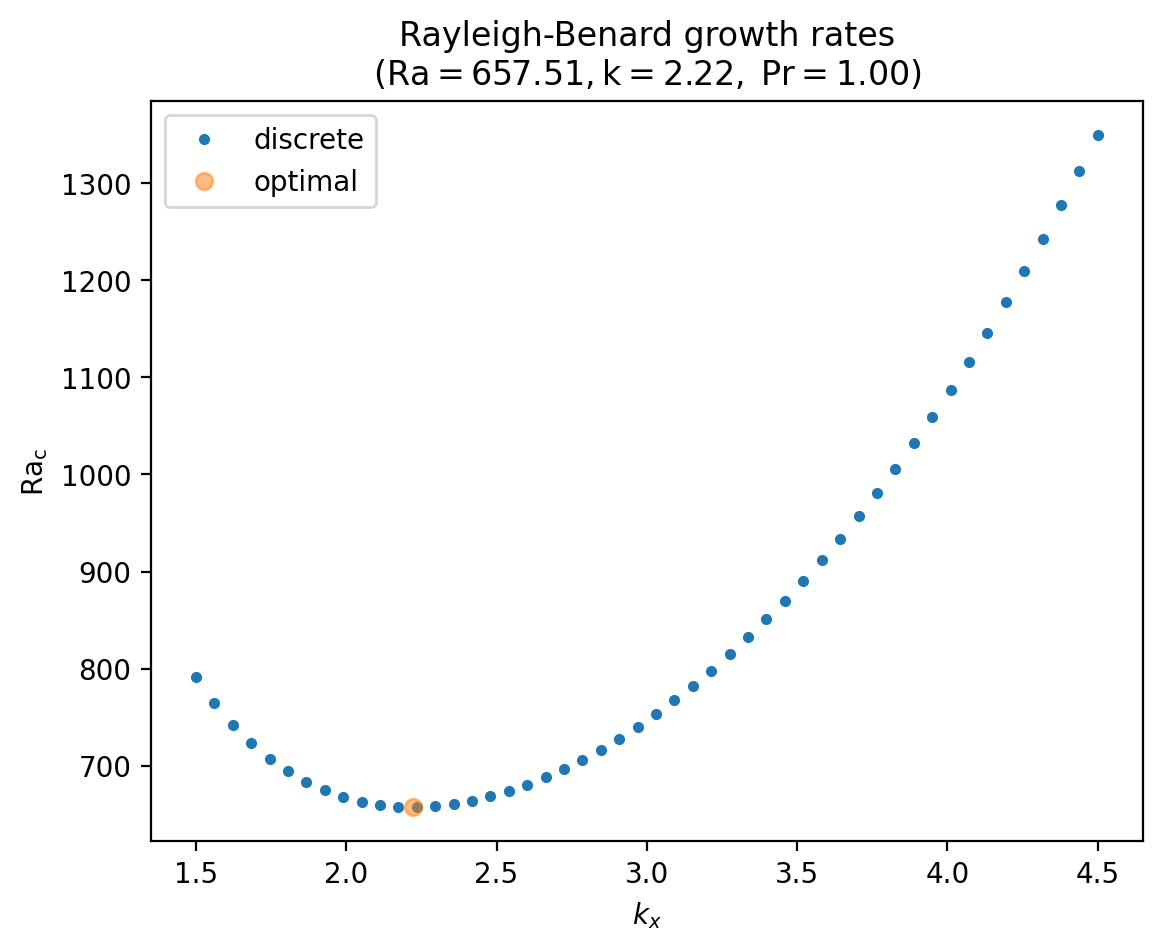

In [133]:
# exact values, from Chandrasekhar
k_c_Chandra  = np.pi/np.sqrt(2)
Ra_c_Chandra = 27 / 4 * np.pi**4

print()
print("from grid search:")
print("critical Ra = {} at kx = {}".format(Ra_c_grid, k_c_grid))
print("from continuous (optimized) search:")
print("critical Ra = {} at kx = {}".format(Ra_c, k_c))
print("exact analytic values:")
print("critical Ra = {} at kx = {}".format(Ra_c_Chandra, k_c_Chandra))
print()
print("errors: |q_c - q_c_chandra|/q_c_chandra")
print("grid:    Ra error = {:8.2g},  kx error = {:7.2g}".format(np.abs(Ra_c_grid-Ra_c_Chandra)/Ra_c_Chandra, np.abs(k_c_grid-k_c_Chandra)/k_c_Chandra))
print("optimal: Ra error = {:8.2g},  kx error = {:7.2g}".format(np.abs(Ra_c-Ra_c_Chandra)/Ra_c_Chandra, np.abs(k_c-k_c_Chandra)/k_c_Chandra))

fig, ax = plt.subplots()
ax.plot(kx_grid, Ra_grid, '.', label='discrete')
ax.plot(k_c, Ra_c, 'o', alpha=0.5, label='optimal')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$\mathrm{Ra_c}$')
ax.set_title('Rayleigh-Benard growth rates\n'+r'($\mathrm{Ra} = %.2f, \mathrm{k} = %.2f,\; \mathrm{Pr} = %.2f$)' %(Ra_c, k_c, Prandtl))
ax.legend()

This does some snazzy things.  First, a coarse grid of eigen problems is solved at various $k_x$.  At each $k_x$, $N_z$ many (potentially) unstable modes are solved for, and the critical mode at each $k_x$ is found and it's $\mathrm{Ra}_c$ is plotted.  These are the blue points.  We use that discrete grid to find the smallest $\mathrm{Ra}_c$, and from there we try to find the best actual critical value by doing a bracketing search.  This is all done using `scipy.optimize`, which is where you should start from when faced with similar problems; techniques like this are related to concepts of minimization and zero or "root" finding.  

The whole procedure takes about 10 seconds on my Macbook Pro M1.

You should see that the values that come out of this are the same as we calculated analytically, and the ones from the optimized search are much better than the initial coarse grid (but the coarse grid may be good enough, depending on your application).

Here's where your part comes in

Participation (Part 2)
------------------
1. Run the code above and verify that the results agree with your analytic solutions.  Calculate the critical $\mathrm{Ra}_c$ and $k_c$ and report them.
2. Modify the code above to use no-slip boundary conditions.  This amounts to setting `u(z=z_bc) = 0`.  Calculate the critical $\mathrm{Ra}_c$ and $k_c$ and report them.
3. Do the same for mixed no-slip/stress-free (bottom, top) boundary conditions.  Calculate the critical $\mathrm{Ra}_c$ and $k_c$ and report them. 
4. Looking at the ordering of $\mathrm{Ra}_c$ and $k_c$ with changing boundary conditions.  Argue, from physical intuition, why this ordering makes sense.

All of your modifications occur in the `add_equation` boundary condition lines.  Think about potentially selecting different boundary conditions via keyword and logical `if` so that you can use the same `Rayleigh_Benard_onset()` for all of your studies.  Re-using code is often a good idea for preventing bugs, since you can fix and test things once and then use many times.

1) Running the code as is we get that 
$$
    \mathrm{Ra}_c \approx 657.5
$$
and
$$ 
    k_c \approx 2.2
$$ 
which align with the analytic solutions.

2) Modifying the code to include no-slip conditions at the top and bottom gives us
$$
    \mathrm{Ra}_c \approx 1707.8
$$
and
$$ 
    k_c \approx 3.1.
$$

3) Finally, putting in mixed conditions (no-slip on the bottom and stress free on the top), we find that
$$
    \mathrm{Ra}_c \approx 1100.65
$$
and
$$ 
    k_c \approx 2.7.
$$
Looking at the wikipedia page for Reyleigh-Benard instability, the Rayleigh number above is the same one mentioned for mixed boundary conditions!

4) From the calculations above, we can see that $ \mathrm{Ra}_c $ and $ k_c $ are the smallest in the stress free environment, get slightly larger in the mixed condition environment, and are the largest in the purely no-slip condition environment. This makes sense intuitively as we include more noslip BCs, the fluid near the surfaces will began to turn over on itself from the lack of fluid motion at the boundary causing instabilities. Hence the critical Reyleigh number increases as we add more noslip conditions.

This numerical approach, incidentally, is also how we would compute convective onset in a non-constant coefficient atmosphere, as you saw in class and in the uploaded AS22 workbook.  We could also handle subcritical bifurcations and oscillatory onset, but that's a bit more sophisticated (you might see it in *ASTR 5410: Waves & Instabilities*, should you choose to take that class).

For problems with oscillatory onset, you would need to solve for $\omega$ as the complex eigenvalue on a 2-d grid in both $k_x$ and $\mathrm{Ra}$, and then search (root-find) this 2-d grid to see where the imaginary part of $\omega = \omega_r + i \omega_i$ is zero (where $\omega_i=0$).  This more general technique can work quite well.  When doing this, one should be careful to reject spurious solutions to the eigenvalue/eigenfunction problem, using a tool like `eigentools` to automatically test for solution convergence.  You need to be a bit careful if you want to do this accurately, but the examples in the [`eigentools` repository](https://github.com/DedalusProject/eigentools) and JOSS paper [(Oishi et al 2021)](https://joss.theoj.org/papers/10.21105/joss.03079) can show you how to do it if and when you need to.  The accuracy of your solution is likely going to be limited by the sophistication of your 2-d grid search, and this is where it's good to lean on solutions like `scipy.optimize` as a starting point.

**To Turn in**:
Send Ben your answers to Part I:1-3 and Part II:1-4 via Canvas, uploading to Asynchronous Exercise 23.  You can do that in this ipynb and upload as an ipynb.  You can also export to PDF or html if you prefer.  Please send by evening, Friday April 28.